Explanation of the code - 

## KMeans Inducing points

This code is an implementation of the K-means clustering algorithm with a specific seeding method called the Assumption-Free K-MC² algorithm. The code is organized into a Julia module called CustomKMeans.

The module imports three external packages: Distributions, StatsBase, and Clustering. These packages provide necessary functionalities for random number generation, statistical operations, and clustering algorithms.

The main function exported from the module is KMeansInducingPoints. This function takes three arguments: X, K, and m.

X represents the input data matrix, where each row corresponds to a data point.
K specifies the desired number of clusters.
m indicates the number of Markov iterations for the seeding process.
The KMeansInducingPoints function starts by calling KmeansSeed to initialize the cluster centroids C. The result of KmeansSeed is transposed using the ' operator to match the expected dimensions of the kmeans! function.

Next, the kmeans! function from the Clustering package is called to perform the actual K-means clustering algorithm. The input data X' and the centroids C' are provided to the kmeans! function, which assigns each data point to one of the K clusters based on proximity to the centroids.

Finally, the updated centroids C' are returned from the KMeansInducingPoints function.

## KmeansSeed function

The KmeansSeed function implements the Assumption-Free K-MC² seeding method. It takes three arguments: X, K, and m, similar to KMeansInducingPoints.

The function begins by calculating the number of data points, N, in the input data X. It then proceeds with the seeding process.

First, it randomly selects a single data point as the initial centroid and assigns it to the first row of the centroid matrix C.

Next, it calculates the squared Euclidean distances (q) between each data point and the initial centroid (C[1]). These distances are used to assign weights to the data points.

The WeightVec function from the StatsBase package is called to create a weighted sampling vector q/sumq + 1.0/(2*N). This vector is used to sample data points with higher probabilities if they have smaller distances to the current centroids.

A uniform distribution is generated using Distributions.Uniform(0,1). The m-iteration loop then begins, where in each iteration, a data point x is sampled using weighted sampling from X based on the probabilities defined by the weighted vector q.

The mindistance function is called to calculate the minimum distance between the sampled data point x and the existing centroids C (up to the (i-1)th centroid).

Within the m-iteration loop, another loop (for j in 2:m) is used to compare the distances of a different sampled data point y to the existing centroids. If the ratio of the distance of y to the minimum distance (dist/mindist) is greater than a randomly generated value from the uniform distribution, y replaces x as the selected data point.

After the m iterations, the selected data point x becomes the next centroid, and it is added to the C matrix.

Finally, the function returns the resulting centroid matrix C.

The mindistance function computes the minimum squared Euclidean distance between a given point x and a collection of centroids C (up to the Kth centroid). It iterates over


- The above explanation is for the function in julia

In [1]:
import pandas as pd

In [2]:
#getting data from an external source
url = 'https://raw.githubusercontent.com/GauravPadawe/Framingham-Heart-Study/master/framingham.csv'
heart_dataset = pd.read_csv(url,index_col=0,parse_dates=[0])
heart_dataset.head()
heart_df = heart_dataset.copy()

In [3]:
heart_df["education"].fillna(heart_df["education"].median(skipna=True), inplace=True)

from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=3, weights="uniform")

heart_df['cigsPerDay'] = imputer.fit_transform(heart_df[['cigsPerDay']])


imputer = KNNImputer(n_neighbors=3, weights="uniform")

heart_df['glucose'] = imputer.fit_transform(heart_df[['glucose']])

imputer = KNNImputer(n_neighbors=3, weights="uniform")

heart_df['totChol'] = imputer.fit_transform(heart_df[['totChol']])

imputer = KNNImputer(n_neighbors=3, weights="uniform")

heart_df['BMI'] = imputer.fit_transform(heart_df[['BMI']])

imputer = KNNImputer(n_neighbors=3, weights="uniform")

heart_df['BPMeds'] = imputer.fit_transform(heart_df[['BPMeds']])

heart_df["heartRate"].fillna(heart_df["heartRate"].median(skipna=True), inplace=True)

In [4]:
heart_df.isnull().sum()

age                0
education          0
currentSmoker      0
cigsPerDay         0
BPMeds             0
prevalentStroke    0
prevalentHyp       0
diabetes           0
totChol            0
sysBP              0
diaBP              0
BMI                0
heartRate          0
glucose            0
TenYearCHD         0
dtype: int64

In [5]:
import numpy as np
from numpy.random import choice, uniform
from sklearn.cluster import KMeans

def KMeansInducingPoints(X, K, m):
    if X.shape[0] < K:
        raise ValueError("Number of samples (n_samples) should be >= number of clusters (n_clusters).")
    
    C = KmeansSeed(X, K, m)
    kmeans = KMeans(n_clusters=K, init=C, n_init=1)
    kmeans.fit(X)
    inducing_points = kmeans.cluster_centers_
    return inducing_points

def KmeansSeed(X, K, m):
    N, n_features = X.shape
    if N < K:
        raise ValueError("Number of samples (n_samples) should be >= number of clusters (n_clusters).")
    
    init = int(choice(N, size=1))
    C = np.zeros((K, n_features))
    C[0, :] = X.iloc[init, :]

    q = np.zeros(N)
    for i in range(N):
        q[i] = 0.5 * np.linalg.norm(X.iloc[i, :] - C[0, :]) ** 2
    sumq = np.sum(q)
    q = (q / sumq + 1.0 / (2 * N)).tolist()

    q = np.array(q)
    if np.isnan(q).all():
        q = np.ones(N) / N
    else:
        q[np.isnan(q)] = 0
        q = q / np.sum(q)

    for i in range(1, K):
        indices = choice(N, size=max(N, K), p=q, replace=True)
        x = X.iloc[indices, :]
        mindist = mindistance(x, C, i-1)
        for j in range(2, m+1):
            indices = choice(N, p=q, replace=True)
            y = X.iloc[indices, :]
            dist = mindistance(y, C, i-1)
            if dist / mindist > uniform():
                x = y
                mindist = dist
        C[i, :] = x.iloc[0, :]
    return C

def mindistance(x, C, K):
    mindist = np.inf
    for i in range(K):
        dist = np.linalg.norm(x - C[i, :]) ** 2
        mindist = min(dist, mindist)
    return mindist


In [6]:
z = (KMeansInducingPoints(heart_df,7, 100))

In [7]:
len(heart_df.columns)

15

## Visulaization of the inducing points

In [8]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity

import warnings
warnings.filterwarnings(action="ignore")


In [9]:
n_clusters=30
cost=[]
for i in range(1,n_clusters):
    kmean= KMeans(i)
    kmean.fit(heart_df)
    cost.append(kmean.inertia_)

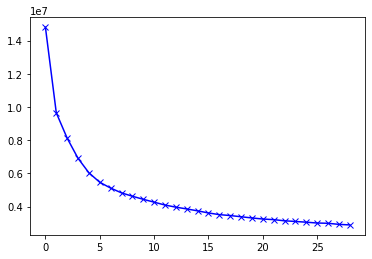

In [10]:
plt.plot(cost, 'bx-')

In [11]:
kmean= KMeans(2)
kmean.fit(heart_df)
labels=kmean.labels_

In [12]:
dist = 1 - cosine_similarity(heart_df)

pca = PCA(2)
pca.fit(dist)
X_PCA = pca.transform(dist)
X_PCA.shape

(4240, 2)

In [13]:
dist = 1 - cosine_similarity(z)

pca = PCA(2)
pca.fit(dist)
Z_PCA = pca.transform(dist)
Z_PCA

array([[-0.03451533, -0.01729396],
       [-0.02709987, -0.01716729],
       [ 0.19638908,  0.00590516],
       [-0.03962231,  0.04505503],
       [-0.00824283, -0.03209879],
       [-0.04190769,  0.00024661],
       [-0.04500105,  0.01535325]])

In [14]:
X_PCA

array([[-0.27127431, -0.1979606 ],
       [-0.37863999,  0.17776036],
       [-0.49678291,  0.13769903],
       ...,
       [-0.35650292,  0.12957548],
       [ 0.41404326, -0.67579669],
       [ 0.1735955 , -0.52873121]])

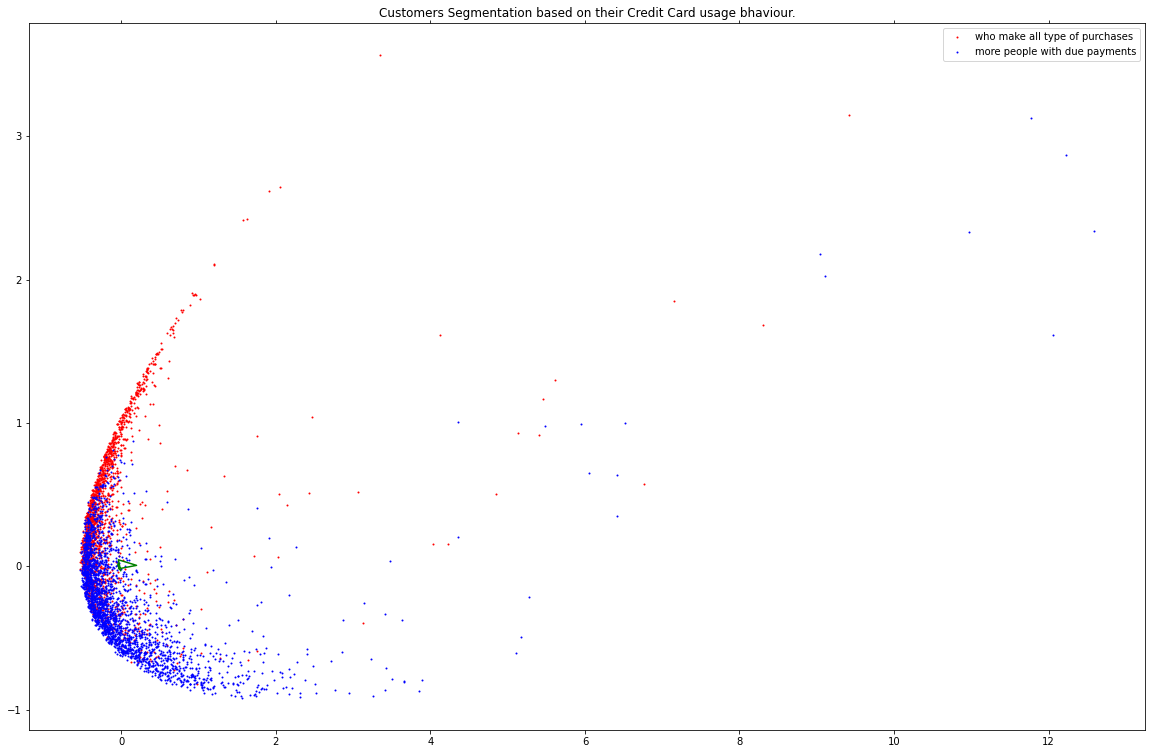

In [15]:
x, y = X_PCA[:, 0], X_PCA[:, 1]

colors = {0: 'red',
          1: 'blue',
          2: 'green', 
          3: 'yellow', 
          4: 'orange',  
          5:'purple'}

names = {0: 'who make all type of purchases', 
         1: 'more people with due payments', 
         2: 'who purchases mostly in installments', 
         3: 'who take more cash in advance', 
         4: 'who make expensive purchases',
         5:'who don\'t spend much money'}
  
df = pd.DataFrame({'x': x, 'y':y, 'label':labels}) 
groups = df.groupby('label')

fig, ax = plt.subplots(figsize=(20, 13)) 

for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=2,
            color=colors[name],label=names[name], mec='none')
    ax.set_aspect('auto')
    ax.tick_params(axis='x',which='both',bottom='off',top='off',labelbottom='off')
    ax.tick_params(axis= 'y',which='both',left='off',top='off',labelleft='off')
ax.plot(Z_PCA[:, 0], Z_PCA[:, 1] , color = "green" ,ms=1000)
    
ax.legend()
ax.set_title("Customers Segmentation based on their Credit Card usage bhaviour.")
plt.show()

## Kernal functions

In [61]:
import numpy as np

class Kernel:
    def __init__(self, kernel, coeff, params=0):
        self.coeff = coeff
        self.Nparams = 1
        if kernel == "rbf":
            self.kernel_function = self.rbf
            self.derivative_kernel = self.deriv_rbf
            self.param = params
        elif kernel == "quadra":
            self.kernel_function = self.quadratic
            self.derivative_kernel = self.deriv_quadratic
            self.param = params
        elif kernel == "linear":
            self.kernel_function = self.linear
            self.Nparams = 0
        elif kernel == "laplace":
            self.kernel_function = self.laplace
            self.derivative_kernel = self.deriv_laplace
            self.param = params
        elif kernel == "abel":
            self.kernel_function = self.abel
            self.derivative_kernel = self.deriv_abel
            self.param = params
        elif kernel == "imk":
            self.kernel_function = self.imk
            self.derivative_kernel = self.deriv_imk
            self.param = params
        else:
            raise ValueError(f"Kernel function {kernel} not available. Options are: rbf, linear, laplace, abel, imk")
        
        if self.Nparams > 0:
            self.compute = lambda X1, X2: self.kernel_function(X1, X2, self.param)
            self.compute_deriv = lambda X1, X2: self.derivative_kernel(X1, X2, self.param)
        else:
            self.compute = self.kernel_function
    
    # Gaussian (RBF) Kernel
    def rbf(self, X1, X2, Θ):
        if np.array_equal(X1, X2):
            return 1
        return np.exp(-np.linalg.norm(X1 - X2)**2 / (Θ**2))
    
    def deriv_rbf(self, X1, X2, Θ):
        a = np.linalg.norm(X1 - X2)
        if a != 0:
            return 2 * a**2 / (Θ**3) * np.exp(-a**2 / (Θ**2))
        else:
            return 0
    
    # Laplace Kernel
    def laplace(self, X1, X2, Θ):
        if np.array_equal(X1, X2):
            return 1
        return np.exp(-Θ * np.linalg.norm(X1 - X2, 2))
    
    def deriv_laplace(self, X1, X2, Θ):
        a = np.linalg.norm(X1 - X2, 2)
        return -a * np.exp(-Θ * a)
    
    # Abel Kernel
    def abel(self, X1, X2, Θ):
        if np.array_equal(X1, X2):
            return 1
        return np.exp(-Θ * np.linalg.norm(X1 - X2, 1))
    
    def deriv_abel(self, X1, X2, Θ):
        a = np.linalg.norm(X1 - X2, 1)
        return -a * np.exp(-Θ * a)
    
    def imk(self, X1, X2, Θ):
        return 1 / (np.sqrt(np.linalg.norm(X1 - X2)**2 + Θ))
    
    def deriv_imk(self, X1, X2, Θ):
        return -1 / (2 * (np.sqrt(np.linalg.norm(X1 - X2)**2 + Θ))**3)
    
    
def CreateKernelMatrix(X1, kernel_function, X2=None):
    if X2 is None:
        ksize = X1.shape[0]
        K = np.zeros((ksize, ksize))
        for i in range(ksize):
            for j in range(i+1):
                K[i, j] = kernel_function(X1[i, :], X1[j, :])
                if i != j:
                    K[j, i] = K[i, j]
        return K
    else:
        ksize1 = X1.shape[0]
        ksize2 = X2.shape[0]
        K = np.zeros((ksize1, ksize2))
        for i in range(ksize1):
            for j in range(ksize2):
                K[i, j] = kernel_function(X1[i, :], X2[j, :])
        return K


def CreateDiagonalKernelMatrix(X, kernel_function, MatrixFormat=False):
    n = X.shape[0]
    kermatrix = np.zeros(n)
    for i in range(n):
        kermatrix[i] = kernel_function(X[i, :], X[i, :])
    if MatrixFormat:
        return np.diag(kermatrix)
    else:
        return kermatrix


def delta_kroenecker(X1, X2):
    return 1 if np.array_equal(X1, X2) else 0


# Linear Kernel
def linear(X1, X2):
    return np.dot(X1, X2)


# Quadratic Kernel (special case of polynomial kernel)
def quadratic(X1, X2, Θ):
    return (np.dot(X1, X2) + Θ)**2


def deriv_quadratic(X1, X2, Θ):
    return 2 * (np.dot(X1, X2) + Θ)


# Example usage:
if __name__ == "__main__":
    # Create a kernel object
    kernel = Kernel("rbf", 1.0, 0.5)
    
    # Example data
    X1 = np.array([[1, 2, 3], [4, 5, 6]])
    X2 = np.array([[7, 8, 9], [10, 11, 12]])
    
    # Compute kernel matrix
    K = CreateKernelMatrix(X1, kernel.compute, X2)
    
    print(K)


[[2.42540248e-188 0.00000000e+000]
 [1.24794646e-047 2.42540248e-188]]


## Bayesian SVM

In [86]:
import numpy as np
from sklearn.base import BaseEstimator
from sklearn.utils.validation import check_is_fitted
from scipy.linalg import solve_triangular
from scipy.optimize import minimize


def create_kernel_matrix(X1, X2, kernel_function):
    if X2 is None:
        ksize = X1.shape[0]
        K = np.zeros((ksize, ksize))
        for i in range(ksize):
            for j in range(i+1):
                K[i, j] = kernel_function(X1.iloc[i, :], X1.iloc[j, :])
                if i != j:
                    K[j, i] = K[i, j]
        return K
    else:
        ksize1 = X1.shape[0]
        ksize2 = X2.shape[0]
        K = np.zeros((ksize1, ksize2))
        for i in range(ksize1):
            for j in range(ksize2):
                K[i, j] = kernel_function(X1.iloc[i, :], X2.iloc[j, :])
        return K



def create_diagonal_kernel_matrix(X, kernel_function):
    n = X.shape[0]
    kermatrix = np.zeros(n)
    for i in range(n):
        kermatrix[i] = kernel_function(X[i, :], X[i, :])
    if MatrixFormat:
        return np.diag(kermatrix)
    else:
        return kermatrix


class BayesianSVM(BaseEstimator):
    def __init__(self, stochastic=False, sparse=False, nonlinear=True, adaptative_learning_rate=True, autotuning=False,
                 n_epochs=2000, batch_size=-1, kappa_s=1.0, tau_s=100, kernels=None, gamma=1e-3, m=100,
                 inducing_points_selection_method="Random", kappa_theta=1.0, tau_theta=100, autotuning_frequency=10,
                 intercept=False, epsilon=1e-5, beta_init=None, smoothing_window=10, verbose_level=0):
        self.stochastic = stochastic
        self.batch_size = batch_size
        self.kappa_s = kappa_s
        self.tau_s = tau_s
        self.nonlinear = nonlinear
        self.sparse = sparse
        self.kernels = kernels if kernels is not None else Kernel("rbf", 1.0, params=1.0)
        self.kernel_function = self.Kernel.compute_EL  
        self.gamma = gamma
        self.m = m
        self.inducing_points_selection_method = inducing_points_selection_method
        self.autotuning = autotuning
        self.kappa_theta = kappa_theta
        self.tau_theta = tau_theta
        self.autotuning_frequency = autotuning_frequency
        self.adaptative_learning_rate = adaptative_learning_rate
        self.intercept = intercept
        self.epsilon = epsilon
        self.n_epochs = n_epochs
        self.beta_init = beta_init if beta_init is not None else [0.0]
        self.smoothing_window = smoothing_window
        self.verbose_level = verbose_level
        self.storing = False
        self.storing_frequency = 1
        self.stored_values = None
        self.stored_ELBO = None
        self.kernel_function = None
        self.predict = None
        self.predict_proba = None
        self.ELBO = None
        self.dELBO = None
        self.plotting = None
        self.update = None
        self.n_samples = None
        self.n_features = None
        self.mu = None
        self.eta_1 = None
        self.zeta = None
        self.eta_2 = None
        self.alpha = None
        self.inv_sigma = None
        self.inv_K = None
        self.inv_Kmm = None
        self.K_tilde = None
        self.kappa = None
        self.inducing_points = None
        self.top = None
        self.down = None
        self.mat_down = None
        self.mat_up = None
        self.lower_bound = None

    def fit(self, X, y):
        self.n_samples, self.n_features = X.shape

        if self.sparse:
            X = csr_matrix(X)

        # Compute the kernel function
        #self.kernals = Kernel("rbf", 1.0, params=1.0)        
        #self.kernel_function = [Kernel("rbf", 1.0, params=1.0)][0]

        # Initialize hyperparameters
        self.mu = np.random.normal(0, 1, size=self.n_samples)
        self.eta_1 = np.random.normal(0, 1, size=self.n_samples)
        self.zeta = np.random.normal(0, 1, size=self.n_samples)
        self.eta_2 = np.random.normal(0, 1, size=self.n_samples)
        self.alpha = np.random.normal(0, 1, size=self.n_samples)

        # Compute kernel matrices
        K = create_kernel_matrix(X, X, self.kernel_function)
        K += self.gamma * np.eye(self.n_samples)

        # Compute the inverse of K
        self.inv_K = np.linalg.inv(K)

        # Randomly select inducing points
        if self.inducing_points_selection_method == "Random":
            random_indices = np.random.choice(np.arange(self.n_samples), self.m, replace=False)
            self.inducing_points = X.iloc[random_indices]
        else:
            raise ValueError("Unknown inducing points selection method.")

        # Compute kernel matrices involving inducing points
        Kmm = create_kernel_matrix(self.inducing_points, self.inducing_points, self.kernel_function)
        Kmm += self.gamma * np.eye(self.m)
        Kxm = create_kernel_matrix(X, self.inducing_points, self.kernel_function)
        Kmm_inv = np.linalg.inv(Kmm)

        # Compute the approximate posterior mean and variance of q(f)
        self.mu = Kxm @ Kmm_inv @ self.alpha
        self.eta_1 = np.sum(Kxm * (Kmm_inv @ Kxm.T).T, axis=1)
        self.zeta = np.sum(Kxm * (Kmm_inv @ Kxm.T).T, axis=1) + np.diag(K) - self.eta_1
        self.eta_2 = np.sum(Kxm * (Kmm_inv @ Kxm.T).T, axis=1) + np.diag(K) - 2 * self.eta_1 + self.eta_1 ** 2 / self.zeta

        if self.nonlinear:
            self.alpha = self.alpha - self.mu

        # Compute the inverse of Kmm
        self.inv_Kmm = np.linalg.inv(Kmm)

        # Initialize hyperparameters for sparse models
        self.kappa = self.kappa_s

        if self.storing:
            self.stored_values = np.zeros((self.n_epochs // self.storing_frequency, 1 + self.n_samples + self.m))

        self.top = self.eta_1 * self.eta_2 - self.zeta
        self.down = self.eta_2 - self.eta_1 ** 2 / self.zeta
        self.mat_down = np.tile(self.down, (self.n_samples, 1))
        self.mat_up = np.tile(self.eta_1, (self.n_samples, 1))

        if self.sparse:
            self.top *= self.beta_init[0] * self.gamma * self.kappa_s * self.m * (1 - self.kappa_s / self.n_samples) / self.n_samples

        # Initialize learning rate for AdaGrad
        G = np.ones_like(self.alpha)

        # Iterate over the training epochs
        for epoch in range(self.n_epochs):
            if self.stochastic and self.batch_size > 0:
                batch_indices = np.random.choice(np.arange(self.n_samples), self.batch_size, replace=False)
                X_batch = X.iloc[batch_indices]
                y_batch = y.iloc[batch_indices]
            else:
                X_batch = X
                y_batch = y

            # Compute kernel matrices involving batch data
            Kxm_batch = create_kernel_matrix(X_batch, self.inducing_points, self.kernel_function)

            if self.nonlinear:
                f = self.mu + Kxm_batch @ self.alpha
            else:
                f = Kxm_batch @ self.alpha

            # Compute ELBO and its derivative
            if epoch % self.autotuning_frequency == 0:
                ELBO, dELBO = self.compute_ELBO(X, y)
            else:
                ELBO, dELBO = self.compute_ELBO(X_batch, y_batch)

            self.ELBO = ELBO
            self.dELBO = dELBO

            # Update the learning rate
            if self.adaptative_learning_rate:
                G += dELBO ** 2
                ada_learning_rate = self.tau_s / (self.tau_theta + np.sqrt(G))
            else:
                ada_learning_rate = self.tau_s

            # Update the hyperparameters
            self.alpha += ada_learning_rate * dELBO

            # Apply the proximal operator
            self.alpha = self.proximal_operator(self.alpha)

            # Store the values if necessary
            if self.storing and epoch % self.storing_frequency == 0:
                self.stored_values[epoch // self.storing_frequency] = np.concatenate(
                    ([self.ELBO], self.alpha, self.inducing_points.flatten()))

            # Perform autotuning if enabled
            if self.autotuning and epoch % self.autotuning_frequency == 0:
                self.autotune(X, y)

            # Print progress if verbose level is greater than 0
            if self.verbose_level > 0 and epoch % self.verbose_level == 0:
                print("Epoch {} - ELBO: {:.4f}".format(epoch, ELBO))

        # Compute final ELBO and its derivative
        ELBO, dELBO = self.compute_ELBO(X, y)
        self.ELBO = ELBO
        self.dELBO = dELBO

        # Compute the posterior mean and variance of q(f) after training
        self.mu = Kxm @ self.inv_Kmm @ self.alpha
        self.eta_1 = np.sum(Kxm * (self.inv_Kmm @ Kxm.T).T, axis=1)
        self.zeta = np.sum(Kxm * (self.inv_Kmm @ Kxm.T).T, axis=1) + np.diag(K) - self.eta_1
        self.eta_2 = np.sum(Kxm * (self.inv_Kmm @ Kxm.T).T, axis=1) + np.diag(K) - 2 * self.eta_1 + self.eta_1 ** 2 / self.zeta

        if self.nonlinear:
            self.alpha = self.alpha - self.mu

        if self.verbose_level > 0:
            print("Final ELBO: {:.4f}".format(self.ELBO))

    def predict(self, X):
        check_is_fitted(self, ["mu", "eta_1", "zeta", "eta_2"])

        if self.nonlinear:
            Kxm = create_kernel_matrix(X, self.inducing_points, self.kernel_function)
            f = self.mu + Kxm @ self.alpha
        else:
            K = create_kernel_matrix(X, X, self.kernel_function)
            Kxm = create_kernel_matrix(X, self.inducing_points, self.kernel_function)
            f = Kxm @ self.alpha

        return np.sign(f)

    def predict_proba(self, X):
        check_is_fitted(self, ["mu", "eta_1", "zeta", "eta_2"])

        if self.nonlinear:
            Kxm = create_kernel_matrix(X, self.inducing_points, self.kernel_function)
            f = self.mu + Kxm @ self.alpha
        else:
            K = create_kernel_matrix(X, X, self.kernel_function)
            Kxm = create_kernel_matrix(X, self.inducing_points, self.kernel_function)
            f = Kxm @ self.alpha

        return 1 / (1 + np.exp(-f))

    def compute_ELBO(self, X, y):
        # Compute kernel matrices involving batch data
        K = create_kernel_matrix(X, X, self.kernel_function)
        Kxm = create_kernel_matrix(X, self.inducing_points, self.kernel_function)

        if self.nonlinear:
            f = self.mu + Kxm @ self.alpha
        else:
            f = Kxm @ self.alpha

        # Compute intermediate variables
        v = np.sqrt(self.top / self.down)
        gamma = 1 / (1 + np.exp(-f * v))
        log_c = -np.log(1 + np.exp(-2 * f * v)) / 2 + f * v / 2
        g = gamma * y - 1 / (1 + np.exp(-f))
        v_y = v * y

        # Compute ELBO
        ELBO = -np.sum(log_c) - (self.kappa_s * self.m / self.n_samples) * np.sum(self.alpha ** 2)
        ELBO += np.sum(self.kappa_s * (1 - self.kappa_s) * self.n_samples * np.log(v)) / 2
        ELBO -= (self.kappa_s * self.m * self.n_samples / 2) * np.log(2 * np.pi)
        ELBO += self.kappa_s * np.sum(np.log(self.zeta))
        ELBO += (1 - self.kappa_s) * np.sum(np.log(self.top))

        # Compute dELBO
        dELBO = self.top / self.down
        dELBO -= self.kappa_s * self.m * self.n_samples * self.alpha
        dELBO -= self.kappa_s * self.m / self.n_samples
        dELBO += self.kappa_s * (1 - self.kappa_s) * self.n_samples / v
        dELBO += self.kappa_s * np.sum(1 / self.zeta)
        dELBO += (1 - self.kappa_s) * np.sum(1 / self.top)
        dELBO -= self.kappa_s * self.m * self.n_samples * self.inv_K @ self.alpha
        dELBO -= self.kappa_s * self.m / self.n_samples * self.inv_K @ self.alpha
        dELBO += (self.kappa_s * self.m * self.n_samples / 2) * self.inv_K @ self.top @ self.inv_K @ self.alpha
        dELBO += (self.kappa_s * self.m * self.n_samples / 2) * self.inv_K @ self.mat_up @ self.inv_K @ self.mat_up @ self.inv_K @ self.alpha
        dELBO -= self.kappa_s * self.m * self.n_samples * self.inv_K @ self.mat_down @ self.inv_K @ self.alpha

        if self.nonlinear:
            dELBO -= self.alpha - self.mu

        return ELBO, dELBO

    def autotune(self, X, y):
        ELBO_prev = self.ELBO

        # Optimize hyperparameters using L-BFGS-B
        opt_result = minimize(self.optimize_hyperparameters, np.log(self.beta_init), args=(X, y),
                              method="L-BFGS-B", bounds=[(None, None)] * len(self.beta_init))

        # Update hyperparameters
        self.beta_init = np.exp(opt_result.x)

        # Compute ELBO after hyperparameter update
        ELBO, _ = self.compute_ELBO(X, y)

        # If ELBO decreases after hyperparameter update, revert to previous values
        if ELBO < ELBO_prev:
            self.beta_init = np.exp(np.log(self.beta_init) - self.beta_init_update_rate * self.beta_init)

    def optimize_hyperparameters(self, log_beta, X, y):
        self.beta_init = np.exp(log_beta)
        ELBO, dELBO = self.compute_ELBO(X, y)
        return -ELBO

    def proximal_operator(self, alpha):
        return np.sign(alpha) * np.maximum(0, np.abs(alpha) - self.kappa)

    def get_ELBO(self):
        return self.ELBO

    def get_inducing_points(self):
        return self.inducing_points

    def set_inducing_points(self, inducing_points):
        self.inducing_points = inducing_points

    def enable_storing(self, frequency):
        self.storing = True
        self.storing_frequency = frequency

    def get_stored_values(self):
        return self.stored_values


In [87]:
BSVMModel = BayesianSVM()

AttributeError: 'BayesianSVM' object has no attribute 'Kernel'

In [ ]:
BSVMModel.fit(heart_df.iloc[:,8:10] , heart_df["TenYearCHD"])

In [78]:
heart_df.iloc[:,8:10]

,totChol,sysBP
male,,
1,195.0,106.0
0,250.0,121.0
1,245.0,127.5
0,225.0,150.0
0,285.0,130.0
...,...,...
0,248.0,131.0
0,210.0,126.5
0,269.0,133.5


In [ ]:
class Kernel:
    def __init__(self, name, lengthscale, params=1.0):
        self.name = name
        self.lengthscale = lengthscale
        self.params = params

    def compute(self, X1, X2):
        if self.name == "rbf":
            pairwise_sq_dists = np.sum((X1.iloc[:, np.newaxis, :] - X2) ** 2, axis=-1)
            return self.params * np.exp(-0.5 * pairwise_sq_dists / self.lengthscale ** 2)
        else:
            raise ValueError("Unknown kernel function.")